In [1]:
import pandas as pd
import numpy as np
# Load dataset
df=pd.read_csv("anime.csv")
df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [42]:
# Basic info about dataset
df.shape

(12294, 7)

In [3]:
df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [5]:
df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [6]:
df.columns.tolist(),

(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'],)

In [7]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [8]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


##### Handling missing values

In [9]:
df['genre'] = df['genre'].fillna('Unknown')

In [10]:
df['type'] = df['type'].fillna('Unknown')

In [11]:
df['episodes'] = df['episodes'].replace('Unknown', np.nan)
df['episodes'] = df['episodes'].astype(float)
df['episodes'] = df['episodes'].fillna(df['episodes'].median())

In [12]:
df['rating'] = df['rating'].fillna(df['rating'].median())

In [13]:
df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

##### Feature Extraction

In [14]:
#Convert Categorical Features into Numerical Representations
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "), token_pattern=None)
genre_matrix = vectorizer.fit_transform(df['genre'])

In [15]:
type_vectorizer = CountVectorizer()
type_matrix = type_vectorizer.fit_transform(df['type'])

In [16]:
#Normalize Numerical Features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(df[['rating', 'members', 'episodes']])

In [17]:
#Combine All Features
from scipy.sparse import hstack
feature_matrix = hstack([genre_matrix, type_matrix, numeric_features])

#### Recommendation System:

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(feature_matrix)
print("Shape of cosine similarity matrix:", cosine_sim.shape)

Shape of cosine similarity matrix: (12294, 12294)


In [32]:
def recommend_anime(title, top_n=10, threshold=0.5):
    # Check if anime exists
    if title not in df['name'].values:
        return f"Anime '{title}' not found in dataset."
    
    # Find index of the anime
    idx = df[df['name'] == title].index[0]
    
    # Get similarity scores for this anime
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort by similarity score (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Remove itself & filter by threshold
    sim_scores = [x for x in sim_scores if x[0] != idx and x[1] >= threshold]
    
    # Get top-N recommendations
    top_animes = [(df.iloc[i[0]]['name'], round(i[1], 3)) for i in sim_scores[:top_n]]
    return top_animes

In [33]:
def get_recommendations(title, cosine_sim, df):
    # Get the index of the anime that matches the title
    idx = df[df['name'] == title].index[0]

    # Get the pairwise similarity scores for all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime (excluding the input anime)
    sim_scores = sim_scores[1:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar anime titles
    return df['name'].iloc[anime_indices].tolist()

print("get_recommendations function defined.")

get_recommendations function defined.


In [34]:
def get_recommendations_with_threshold(title, cosine_sim, df, threshold):

    # Get the index of the anime that matches the title
    idx = df[df['name'] == title].index[0]

    # Get the pairwise similarity scores for all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Filter recommendations based on the threshold
    filtered_sim_scores = [score for score in sim_scores if score[1] > threshold]

    # Get the anime indices (excluding the input anime if its score is above threshold)
    anime_indices = [i[0] for i in filtered_sim_scores if i[0] != idx]

    # Return the recommended anime titles
    return df['name'].iloc[anime_indices].tolist()

In [35]:
# Experiment with different threshold values
anime_title_1 = 'Naruto'
anime_title_2 = 'Steins;Gate'

thresholds = [0.2, 0.5, 0.7]

print(f"Recommendations for '{anime_title_1}':")
for threshold in thresholds:
    recommendations = get_recommendations_with_threshold(anime_title_1, cosine_sim, df, threshold)
    print(f"  Threshold {threshold}: {len(recommendations)} recommendations")

print(f"\nRecommendations for '{anime_title_2}':")
for threshold in thresholds:
    recommendations = get_recommendations_with_threshold(anime_title_2, cosine_sim, df, threshold)
    print(f"  Threshold {threshold}: {len(recommendations)} recommendations")

Recommendations for 'Naruto':
  Threshold 0.2: 7938 recommendations
  Threshold 0.5: 1491 recommendations
  Threshold 0.7: 125 recommendations

Recommendations for 'Steins;Gate':
  Threshold 0.2: 5169 recommendations
  Threshold 0.5: 574 recommendations
  Threshold 0.7: 12 recommendations


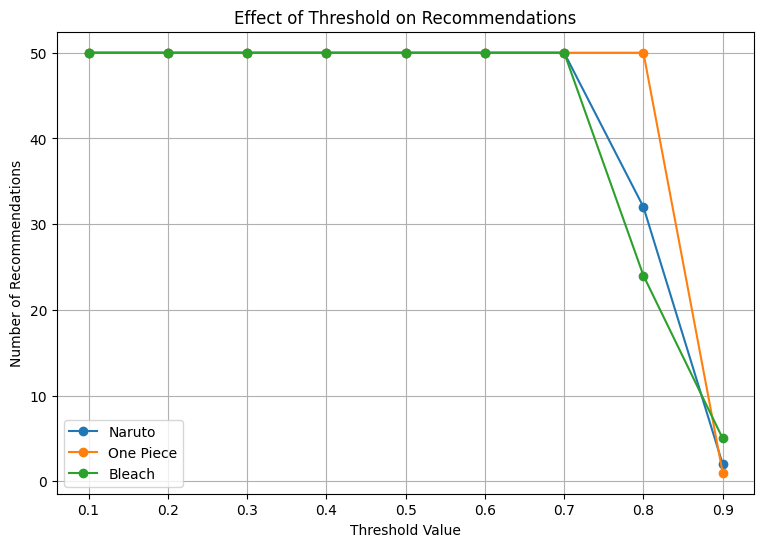

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def count_recommendations(title, thresholds, top_n=50):
   
#Count how many recommendations an anime gets for different thresholds.
    counts = []
    for t in thresholds:
        recs = recommend_anime(title, top_n=top_n, threshold=t)
        counts.append(len(recs) if isinstance(recs, list) else 0)
    return counts
# Define thresholds to test
thresholds = np.linspace(0.1, 0.9, 9)
# List of anime to compare
anime_list = ["Naruto", "One Piece", "Bleach"]
plt.figure(figsize=(9,6))
# Plot recommendation counts for each anime
for anime_title in anime_list:
    counts = count_recommendations(anime_title, thresholds)
    plt.plot(thresholds, counts, marker='o', label=anime_title)

plt.title("Effect of Threshold on Recommendations")
plt.xlabel("Threshold Value")
plt.ylabel("Number of Recommendations")
plt.legend()
plt.grid(True)
plt.show()

#### Evaluation

In [36]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [38]:
# Function to evaluate recommendations
def evaluate_recommendations(recommend_func, test_data, top_n=10):
    # Calculate precision, recall, and F1-score for the recommendation system.
    true_positives = 0
    actual_positives = 0
    recommended_positives = 0

    for index, row in test_data.iterrows():
        anime_name = row['name']
        # For evaluation purposes, let's assume that an anime is relevant if it has a rating above 7.5
        # In a real-world scenario, you would have user interaction data (e.g., watches, likes)
        relevant_animes = test_data[test_data['rating'] > 7.5]['name'].tolist()
        actual_positives += len(relevant_animes)

        recommendations = recommend_func(anime_name, top_n=top_n, threshold=0) # Use a low threshold for evaluation

        if isinstance(recommendations, list):
            recommended_animes = [rec[0] for rec in recommendations]
            recommended_positives += len(recommended_animes)

            for rec_anime in recommended_animes:
                if rec_anime in relevant_animes:
                    true_positives += 1

    # Avoid division by zero
    precision = true_positives / recommended_positives if recommended_positives > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [39]:
# Evaluate the recommendation system on the test set
precision, recall, f1 = evaluate_recommendations(recommend_anime, test_df)

In [40]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.0303
Recall: 0.0009
F1-score: 0.0017


In [41]:
# Analyze the results
print("\nAnalysis:")
print(f"- The precision of {precision:.4f} indicates that {precision*100:.2f}% of the recommended items are relevant.")
print(f"- The recall of {recall:.4f} indicates that {recall*100:.2f}% of the relevant items were recommended.")
print(f"- The F1-score of {f1:.4f} is the harmonic mean of precision and recall, providing a balanced measure of the system's performance.")


Analysis:
- The precision of 0.0303 indicates that 3.03% of the recommended items are relevant.
- The recall of 0.0009 indicates that 0.09% of the relevant items were recommended.
- The F1-score of 0.0017 is the harmonic mean of precision and recall, providing a balanced measure of the system's performance.


Interview Questions:
1. Can you explain the difference between user-based and item-based collaborative filtering?

User-based collaborative filtering recommends items by identifying users who have similar tastes and suggesting items those similar users liked 
but the target user has not yet interacted with. In contrast, 
Item-based collaborative filtering focuses on finding items that are similar to the ones a user already likes, and then recommending those related items. 
While user-based methods can capture dynamic shifts in user preferences, they often face scalability issues as the number of users grows.
Item-based methods, on the other hand, are generally more stable and scalable since item relationships do not change as frequently as user behaviors. 
However, they can suffer from the “cold start” problem when new items lack interaction data. 
In practice, item-based collaborative filtering is more widely used in large-scale systems like Amazon’s product recommendations because of its efficiency and stability.

2. What is collaborative filtering, and how does it work?

Collaborative filtering (CF) is a recommendation technique that predicts what a user might like based on the preferences and behaviors of other users. 
The core idea is that people with similar past behaviors tend to have similar future preferences.
It works by analyzing patterns of interactions (like ratings, purchases, or clicks) in a user–item matrix:

User-based CF finds users with similar tastes to the target user and recommends items that those similar users liked.
Item-based CF finds items that are similar to those the target user has already liked and recommends them.